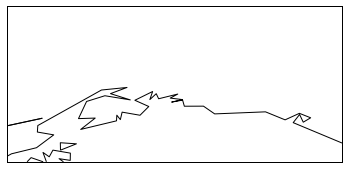

In [19]:
# Create a map in cylindrical coordinate system
# which has as corner lat/lon values teh corner
# values from the wrfout file

import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.basemap as bm
import netCDF4

#WRFOUT_FILE_PATH = 'wrfout_d01_2017-09-11_06:00:00' # Florida
WRFOUT_FILE_PATH ='wrfout_d01_2018-08-13_00:00:00' #Alaska

dataset = netCDF4.Dataset(WRFOUT_FILE_PATH, 'r')

# Get the 2D arrays of lats and lons, corresponding to 
# each data grid point
# Recall that dimensions ar (Time, south_north, west_east)

XLAT = dataset.variables['XLAT'][:]
XLON = dataset.variables['XLONG'][:]

#Get the lower left and upper right corner lat and lon
ll_lat = XLAT[0, 0, 0]; ll_lon = XLON[0, 0, 0]
ur_lat = XLAT[0, -1, -1]; ur_lon = XLON[0, -1, -1]

# This is all we need to define a cylindrical map project
the_map = bm.Basemap(projection='cyl',
                    llcrnrlon=ll_lon,
                    llcrnrlat=ll_lat,
                    urcrnrlon=ur_lon,
                    urcrnrlat=ur_lat,
                    resolution= 'c', 
                    area_thresh=1000.0)
the_map.drawcoastlines()

# # Plot Miami
# miami_lat = 25.76
# miami_lon = -80.19

# # Get the map coordinates
# miami_mapx, miami_mapy = the_map(miami_lon, miami_lat)

# # Plot it
# the_map.plot(miami_mapx, miami_mapy, 'bo')
# plt.text(miami_mapx, miami_mapy, "Miami")

# LOCATIONS = {
#     'name' : ['Miami', 'Etlanna', 'Nahwlins'],
#     'lat'  : [25.26, 33.75, 29.95],
#     'lon'  : [-80.19, -84.39, -90.07]
# }

# # Get the map coordinates
# locations_mapx, locations_mapy = the_map(LOCATIONS['lon'], LOCATIONS['lat'])

# #Plot the points
# the_map.plot(locations_mapx, locations_mapy, 'bo')

# # Plot the names
# for name, xpt, ypt in zip(LOCATIONS['name'], locations_mapx, locations_mapy):
#     plt.text(xpt, ypt, name)

# # 2D surface pressure
# PSFC = dataset.variables['PSFC'][:] * 0.01  # Millibars

# #2d map coordinates
# map2d_x, map2d_y = the_map(XLON[0,:,:], XLAT[0,:,:])

# the_map.contourf(map2d_x, map2d_y, PSFC[0,:,:])

# plt.colorbar()
# plt.show

/usr/lib/python3/dist-packages/mpl_toolkits/basemap/__init__.py:3644: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  xx = x[x.shape[0]/2,:]


<function matplotlib.pyplot.show(*args, **kw)>

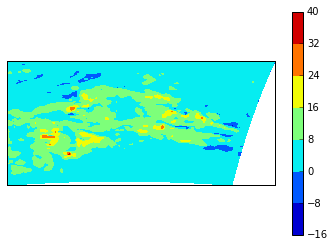

In [20]:
U_staggered = dataset.variables['U'][:]
V_staggered = dataset.variables['V'][:]

#Create WS10
WS = (np.sqrt(U10**2 + V10**2)) *1.94384 #convert the units to knots

def destagger_uv(ustagger=None, vstagger=None):
   
    """
    Creates arrays u and v on grid points rather than their native mass points
    by assigning to each grid point the average of the adjacent mass points

    Assumes ustagger has dimensions (Time, bottom_top, south_north, west_east_stag)
    Assumes vstagger has dimensions (Time, bottom_top, south_north_stag, west_east)

    By averaging, creates U and V arrays of dimensions 
    (Time, bottom_top, south_north, west_east)
    """

    # We can compute the dimensions of the arrays through knowledge of 
    # their shapes
    Time_dim = ustagger.shape[0]
    bottom_top_dim = ustagger.shape[1]
    south_north_dim = ustagger.shape[2]
    west_east_stag_dim = ustagger.shape[3]
    south_north_stag_dim = vstagger.shape[2]
    west_east_dim = vstagger.shape[3]

    # Allocate and shape the arrays that will be returned
    u = v = np.ndarray( (Time_dim, bottom_top_dim, south_north_dim, west_east_dim) )

    # Now the destaggering - each grid point in the destaggered array is
    # the average of the adjacent mass points in the staggered arrays

    for j in np.arange(west_east_dim):
        u[:,:,:,j] = ( ustagger[:,:,:,j] + ustagger[:,:,:,j+1] ) / 2.0
    for i in np.arange(south_north_dim):
        v[:,:,i,:] = ( vstagger[:,:,i,:] + vstagger[:,:,i+1,:] ) / 2.0    

    return u, v

U10, V10 = destagger_uv(U_staggered, V_staggered)


#2d map coordinates
map2d_x, map2d_y = the_map(XLON[0,:,:], XLAT[0,:,:])

LLWS = WS[0,1,:,:] - WS[0,0,:,:]
the_map.contourf(map2d_x, map2d_y, LLWS[:,:])

plt.colorbar()
plt.show